In [17]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm as tqdm
import pandas as pd
import os

import import_ipynb
import data_transformation
import unittest
from sklearn.model_selection import train_test_split 

In [2]:
data_class = data_transformation.data_transformation(path_data = "/data/data_curated_20180219/curated_training_data_no_mass_spec.csv",
                                                     path_mhc = "/data/aligned_mhc_dataset.csv",
                                                     allele_name = None,
                                                     quant_data = True,
                                                     encoding = "one-hot")

pep, mhc, target = data_class.__getitem__()

pep = np.expand_dims(pep, axis=1)
mhc = np.expand_dims(mhc, axis=1)
inp = np.hstack((pep, mhc))
print(inp.shape)

X_train, X_test, y_train, y_test = train_test_split(inp, target.T, test_size=0.2, random_state=42)

(137377, 2, 34, 20)


## Train and Test set have same distribution of the target values

(array([2.2000e+01, 5.6100e+02, 4.8570e+04, 1.9681e+04, 1.7273e+04,
        1.3543e+04, 7.4100e+03, 2.5370e+03, 2.9500e+02, 9.0000e+00]),
 array([-1.43017093, -1.21535945, -1.00054797, -0.7857365 , -0.57092502,
        -0.35611354, -0.14130206,  0.07350942,  0.2883209 ,  0.50313238,
         0.71794386]),
 <a list of 10 Patch objects>)

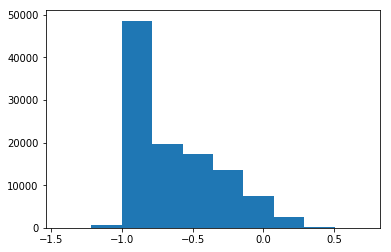

In [18]:
plt.hist(y_train.flatten())

(array([2.1000e+01, 1.5730e+03, 1.2146e+04, 4.8900e+03, 3.8830e+03,
        2.9350e+03, 1.6540e+03, 3.5800e+02, 1.3000e+01, 3.0000e+00]),
 array([-1.34103584, -1.13275871, -0.92448158, -0.71620445, -0.50792732,
        -0.29965019, -0.09137306,  0.11690408,  0.32518121,  0.53345834,
         0.74173547]),
 <a list of 10 Patch objects>)

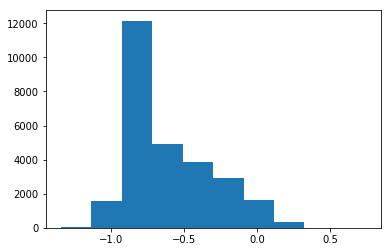

In [25]:
plt.hist(y_test.flatten())

## Naive Model taking only the mean value lead to RMSE of 0.3

In [43]:
pred = np.full(len(y_test.flatten()), np.mean(y_test.flatten()))

In [47]:
error = pred - y_test.flatten()
error2 = np.square(error)
rmse = np.sqrt(np.mean(error2))
rmse

0.2928557865457815

## Comparision of input values of test and train set

In [11]:
results_max = []
for j in tqdm(range(100)):#len(X_train))):
    a = X_train[j, 0][~np.all(X_train[j, 0] == 0, axis=1)]
    mhc_a = X_train[j, 1][~np.all(X_train[j, 1] == 0, axis=1)]
    results = []
    for i in range(len(X_test)):
        b = X_test[i, 0][~np.all(X_test[i, 0] == 0, axis=1)]
        mhc_b = X_test[i, 1][~np.all(X_test[i, 1] == 0, axis=1)]
        #print(b.size)
        if mhc_a.size == mhc_b.size: #here for now easier looping
            if a.size > b.size:
                temp_b = np.zeros(a.shape)
                temp_b[:b.shape[0],:b.shape[1]] = b
                temp = np.sum(np.all(a == temp_b, axis=1))
            elif a.size < b.size:
                temp_a = np.zeros(b.shape)
                temp_a[:a.shape[0],:a.shape[1]] = a
                temp = np.sum(np.all(temp_a == b, axis=1))
            else:
                temp = np.sum(np.all(a == b, axis=1))
            temp_mhc = np.sum(np.all(mhc_a == mhc_b, axis=1))
            if a.shape[1] >= b.shape[1]:
                results.append([temp / a.shape[0], temp_mhc / mhc_a.shape[0]])
            else:
                results.append([temp / b.shape[0], temp_mhc / mhc_a.shape[0]])
    #print(results)
    results_max.append(max(np.mean(results, axis = 1)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


(array([ 3.,  0.,  3.,  0., 10.,  5.,  3., 10.,  6.,  9.,  7.,  4.,  6.,
         4.,  8.,  1.,  2., 12.,  3.,  4.]),
 array([0.65  , 0.6675, 0.685 , 0.7025, 0.72  , 0.7375, 0.755 , 0.7725,
        0.79  , 0.8075, 0.825 , 0.8425, 0.86  , 0.8775, 0.895 , 0.9125,
        0.93  , 0.9475, 0.965 , 0.9825, 1.    ]),
 <a list of 20 Patch objects>)

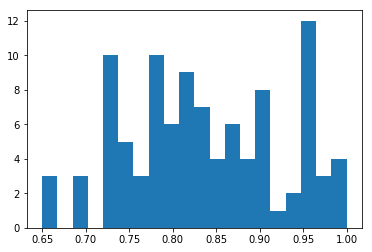

In [12]:
plt.hist(results_max, bins = 20)

(array([ 13.,   0.,  40.,   0.,  48., 104.,   0.,   3.,   2.,  24.,   6.,
          0.,   8.,   1.,   0.,   0.,  41.,   1.,   0., 709.]),
 array([0.375  , 0.40625, 0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 ,
        0.59375, 0.625  , 0.65625, 0.6875 , 0.71875, 0.75   , 0.78125,
        0.8125 , 0.84375, 0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 <a list of 20 Patch objects>)

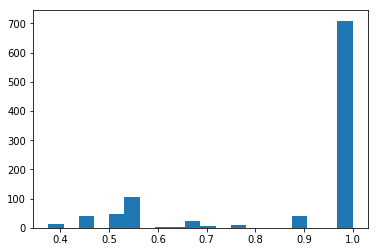

In [161]:
plt.hist(results_max, bins = 20)

## Order Pandas by levensthein distance

In [124]:
cwd = os.getcwd()
os.chdir('..')
os.chdir('..')
os.chdir('..')
current_path = os.getcwd()
df = pd.read_csv(current_path + "/data/data_curated_20180219/curated_training_data_no_mass_spec.csv")
os.chdir(cwd) 
df = df[df.measurement_type == "quantitative"].loc[:, ['peptide', 'allele']].drop_duplicates().reset_index(drop = True)

In [125]:
df.head()

,peptide,allele
0,AENDTLVVSV,BoLA-1*21:01
1,NQFNGGCLLV,BoLA-1*21:01
2,AAHCIHAEW,BoLA-2*08:01
3,AAKHMSNTY,BoLA-2*08:01
4,DSYAYMRNGW,BoLA-2*08:01


In [152]:
t = df.peptide.values

In [ ]:
from distance import levenshtein      
import numpy as np
from sklearn.cluster import dbscan


t = df.peptide.values
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein(t[i], t[j])

X = np.arange(len(t)).reshape(-1, 1)
te = dbscan(X, metric=lev_metric, eps=5, min_samples=2, algorithm='brute', n_jobs = -1)

RQYERYTAL 	19
73 	RVMAIFMAL 	19
74 	RVRPKKEVL 	19
75 	SLKERIDML 	

In [ ]:
t.shape

In [ ]:
te[0].shape

In [ ]:
te[1].shape

In [ ]:
te[1]

In [ ]:
d = {'col1': t, 'col2': te[1]}
pd.DataFrame(d)